# Vizualiation of predicitons 

## Predictions of the top performing models according the dominance analysis and scpm ranking

### MLP - Top model according to the SCPM of -3.88 and dominance count of 3

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

2024-11-01 23:46:14.651379: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 23:46:14.653683: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 23:46:14.701476: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 23:46:14.702660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 23:46:15.526405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()

        # First Dense layer with Batch Normalization
        model.add(tf.keras.layers.Dense(units=256, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())  # Add BatchNormalization
        model.add(tf.keras.layers.Dropout(rate=0.25))
        # Subsequent Dense layers with Batch Normalization
        model.add(tf.keras.layers.Dense(units=128, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=64, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=32, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=16, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))

        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )

        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [4]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [5]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [6]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "209",
    "Plant": "AM",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

In [7]:
weights_path = "../../../../models/global_models/203/mlp/c/pre_training/"
model_name = "mlp_chemical_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

# Reading the dataset

In [8]:
df = pd.read_csv("../../../../data/processed/203/c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [9]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### Dropping columns - additional step

These columns had to be dropped since the global set has not enough mineralogical data.

In [10]:
df_copy = df_copy.drop(
    [
        "TiO2",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [11]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

## 1.2. Blocking Time Series Cross Validation

In [12]:
set_seeds()
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
scores_final = None
results_repeats = {}

for repeat in range(repeats):
    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )
    cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
    scores = cross_validate(
        pipeline,
        x,
        y,
        scoring=METRICS,
        cv=cv,
        # n_jobs=None,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    results_repeats[repeat] = scores

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]


print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores_final, METRICS, METRICS_DICT)

scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

2024-11-01 23:46:18.502784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-01 23:46:18.502838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-11-01 23:46:18.502848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-11-01 23:46:18.503057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-11-01 23:46:18.503092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-11-01 23:46:18.503100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.136 (0.104)
MAE: -0.873 (0.084)
MAPE: -0.021 (0.002)
R2: 0.962 (0.008)


******
[TEST]
******
RMSE: -1.822 (0.536)
MAE: -1.290 (0.324)
MAPE: -0.031 (0.007)
R2: 0.899 (0.049)


Minutes Elapsed:  12.008249938488007


<IPython.core.display.Javascript object>

## Plotting the Predictions

In [13]:
def get_predictions_df(scores):
    df_pred = pd.DataFrame()
    df_pred["DATE"] = dates.copy()
    df_pred["CS28"] = y.copy()
    df_pred["CS28_PRED"] = np.nan
    df_pred["SET"] = ""
    df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
    df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

    for idx, pipeline in enumerate(scores["estimator"]):
        index_train = scores["indices"]["train"][idx]
        index_test = scores["indices"]["test"][idx]
        index_preds = np.concatenate([index_train, index_test])

        # results = scores["estimator"][0].predict(x.loc[index_preds])
        results = pipeline.predict(x.loc[index_preds])
        df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
        df_pred.loc[index_train, "SET"] = "TRAIN"
        df_pred.loc[index_test, "SET"] = "TEST"
        df_pred.loc[index_train, "FOLD"] = idx + 1
        df_pred.loc[index_test, "FOLD"] = idx + 1
    df_pred = df_pred.dropna()
    return df_pred

<IPython.core.display.Javascript object>

In [14]:
dfs = []
for repeat in range(repeats):
    scores = results_repeats[repeat]
    df_pred = get_predictions_df(scores)
    df_pred["REPEAT"] = repeat
    dfs.append(df_pred)

df_pred = pd.concat(dfs)

<IPython.core.display.Javascript object>

In [15]:
df_pred = dfs[0]
df_pred["CS28_PRED"] = (
    dfs[0]["CS28_PRED"] + dfs[1]["CS28_PRED"] + dfs[2]["CS28_PRED"]
) / 3

<IPython.core.display.Javascript object>

In [16]:
# df_copy_merge = (
#     df_copy.reset_index(drop=True)
#     .merge(
#         df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
#     )
#     .drop("REPEAT", axis=1)
# )

# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "AM"
# df_copy_merge.to_excel("global_model_mlp_btsscv_203_c.xlsx", index=False)
# df_copy_merge.to_csv("global_model_mlp_btsscv_203_c.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,REPEAT
0,2017-08-01 15:36:00,49.03,47.118362,TRAIN,CP II-F40,1.0,0
1,2017-08-02 15:41:00,46.93,46.691483,TRAIN,CP II-F40,1.0,0
2,2017-08-02 15:41:00,33.20,34.679947,TRAIN,CP II-E32,1.0,0
3,2017-08-04 15:41:00,46.80,47.815670,TRAIN,CP II-F40,1.0,0
4,2017-08-04 15:41:00,34.40,34.406219,TRAIN,CP II-E32,1.0,0
...,...,...,...,...,...,...,...
2820,2023-03-27 11:00:00,47.06,45.624348,TEST,CP VARI,5.0,0
2821,2023-03-27 11:00:00,33.21,34.639534,TEST,CP II-E32,5.0,0
2822,2023-03-28 11:01:00,33.28,34.945869,TEST,CP II-E32,5.0,0
2823,2023-03-28 11:01:00,47.11,46.028572,TEST,CP II-E40,5.0,0


<IPython.core.display.Javascript object>

In [18]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

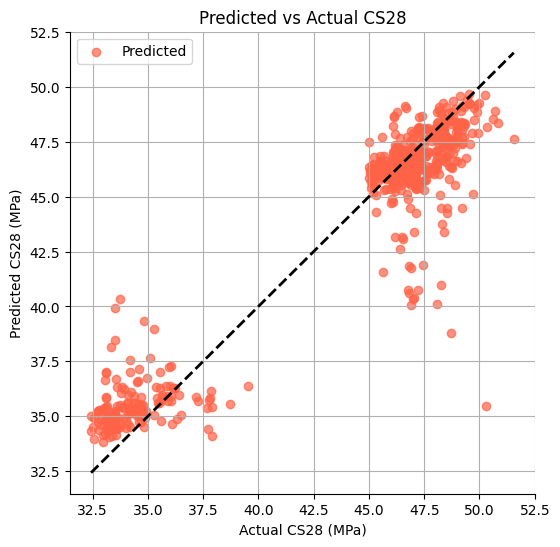

<IPython.core.display.Javascript object>

In [20]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_203_c_global_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


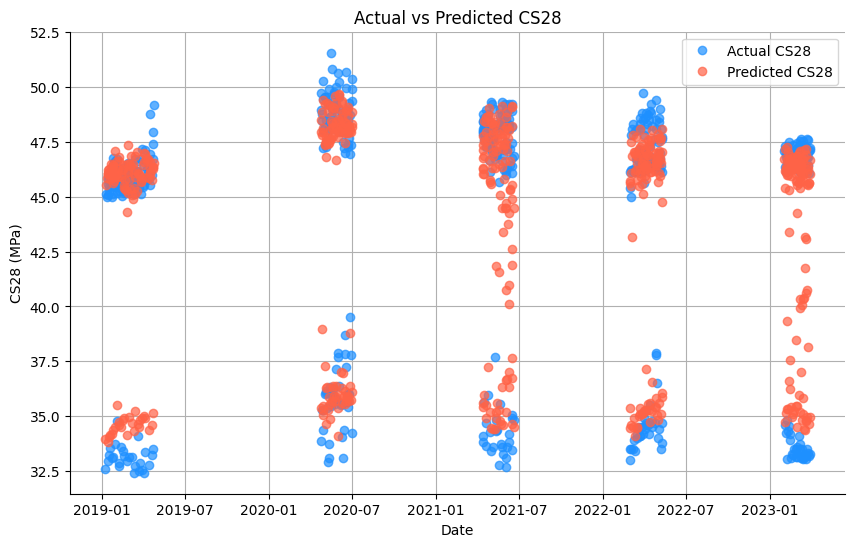

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_global_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [22]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [23]:
perm_importances = []

for repeat in range(repeats):
    scores = results_repeats[repeat]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_index = indices["test"]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_indexes = indices["test"]

    for i, (pipeline, test_idx) in tqdm(enumerate(zip(estimators, test_indexes))):
        result = permutation_importance(
            pipeline,
            x.iloc[test_idx],
            y[test_idx],
            n_repeats=10,
            random_state=SEED,
            n_jobs=1,
            scoring="r2",
        )
        perm_importances.append(result.importances_mean)

5it [00:28,  5.69s/it]
5it [00:28,  5.78s/it]
5it [00:29,  5.83s/it]


<IPython.core.display.Javascript object>

In [24]:
# Average importances across folds
mean_importances = np.mean(perm_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(perm_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [25]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

<IPython.core.display.Javascript object>

In [32]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
    "TiO2": r"$\mathrm{TiO_2}$",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


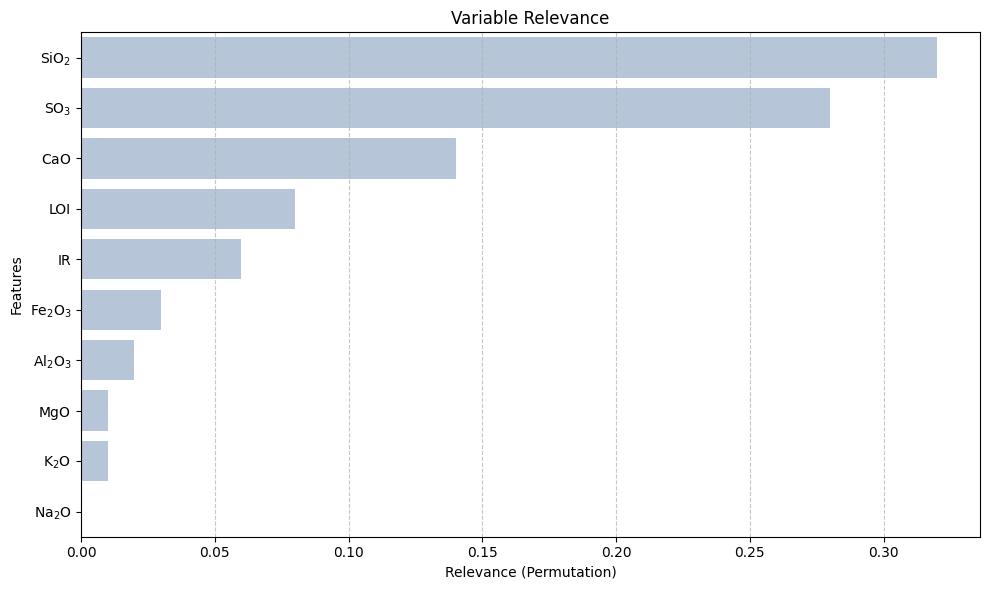

<IPython.core.display.Javascript object>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

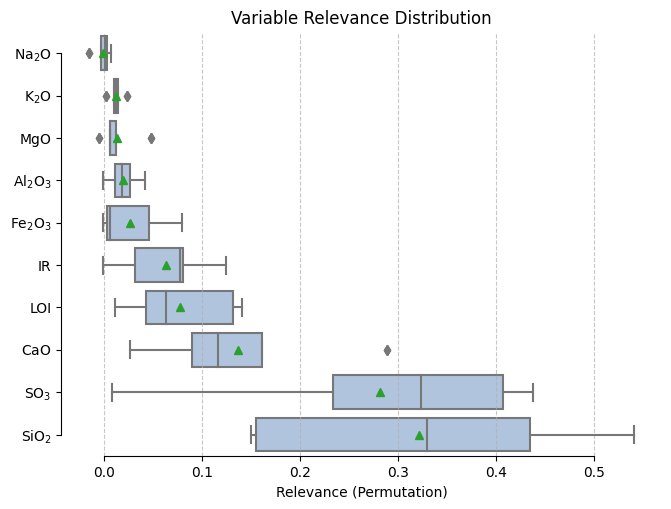

<IPython.core.display.Javascript object>

In [37]:
perm_importances_df = importances_df

df_importances = perm_importances_df

# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]


# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_global_cm_btiss_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

### Transformer - Top model dominant model SCPM of -3.65 and dominance count of 3 each model

In [38]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

# To run cross validation parallelized
from joblib import Parallel, delayed

import joblib

import matplotlib

<IPython.core.display.Javascript object>

# Functions and definitions

In [39]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [40]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [41]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return imputer, dataset

<IPython.core.display.Javascript object>

In [42]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return scaler, dataset

<IPython.core.display.Javascript object>

In [43]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    imputer, dataset = impute_data(dataset, imputer, imputer_params)
    scaler, dataset = transform_data(dataset, transformer)
    return imputer, scaler, dataset

<IPython.core.display.Javascript object>

In [44]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(**estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return model, score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

In [45]:
def custom_cross_validate_parallelized(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
    n_jobs=-1,
    REPEAT=0,  # Add REPEAT as a parameter
):
    def process_fold(
        train_index, test_index, dates, cement_types, x, y, repeat_num, fold_num
    ):
        dataset = {
            "dates_train": dates[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
            "x_train": x.loc[train_index].reset_index(drop=True),
            "y_train": y[train_index].reset_index(drop=True),
            "dates_test": dates[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
            "x_test": x.loc[test_index].reset_index(drop=True),
            "y_test": y[test_index].reset_index(drop=True),
        }

        set_seeds(SEED + repeat_num)

        # Preprocess the dataset
        imputer, scaler, dataset = preprocess_data(
            dataset, Transform, Imputer, imputer_params
        )

        # Generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        estimator, score = train_and_evaluate_model(
            Estimator, dataset, estimator_params
        )

        # Create a directory to save models if it doesn't exist
        model_dir = f"models_repeat{repeat_num}_fold{fold_num}"
        os.makedirs(model_dir, exist_ok=True)

        # Save the imputer
        imputer_filename = os.path.join(model_dir, f"imputer.joblib")
        joblib.dump(imputer, imputer_filename)

        # Save the scaler
        scaler_filename = os.path.join(model_dir, f"scaler.joblib")
        joblib.dump(scaler, scaler_filename)

        # Save the Keras model
        # model_filename = os.path.join(model_dir, f"keras_model.h5")
        # estimator.model.save(model_filename)
        # Save the Keras model in SavedModel format
        model_filename = os.path.join(model_dir, f"keras_model")  # No extension
        estimator.model.save(model_filename, save_format="tf")  # Specify save_format

        # Optionally, return the filenames
        filenames = {
            "imputer": imputer_filename,
            "scaler": scaler_filename,
            "model": model_filename,
        }

        return score, filenames

    # Use enumerate to get fold numbers
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            train_index, test_index, dates, cement_types, x, y, REPEAT, fold_num
        )
        for fold_num, (train_index, test_index) in enumerate(cv.split(x))
    )

    # Unpack scores and filenames
    scores, filenames_list = zip(*results)

    # Process scores as before
    scores_final = {key: [] for key, _ in scores[0].items()}
    for scores_dict in scores:
        for key, value in scores_dict.items():
            scores_final[key] += [value]

    # Optionally, collect filenames
    # filenames_list contains the filenames for each fold

    results = [scores_final]
    return filenames_list, results

<IPython.core.display.Javascript object>

In [46]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = self.params.get("batch_size", 16)
        self.epochs = self.params.get("epochs", 300)
        self.verbose = self.params.get("verbose", 0)
        self.callbacks = self.params.get("callbacks", None)
        self.validation_split = self.params.get("validation_split", 0.0)
        self.num_features = self.params.get("num_features", x.shape[-1])

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
            dropout_rate=self.params.get("dropout_rate", 0.1),
            activation=self.params.get("activation", "relu"),
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

    def save(self, filepath):
        self.model.save(filepath)

<IPython.core.display.Javascript object>

In [47]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [48]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

In [49]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [50]:
def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [51]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [52]:
def get_transformer_params(
    timesteps=1,
    num_features=0,
    num_heads=1,
    num_layers_enc=1,
    num_feed_forward=16,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
):
    params = {}
    params["num_features"] = num_features
    params["timesteps"] = timesteps
    params["num_heads"] = num_heads
    params["num_layers_enc"] = num_layers_enc
    params["num_feed_forward"] = num_feed_forward
    params["verbose"] = verbose
    params["dropout_rate"] = dropout_rate
    params["activation"] = activation
    params["batch_size"] = batch_size
    params["epochs"] = epochs
    params["callbacks"] = callbacks
    params["validation_split"] = validation_split

    return params

<IPython.core.display.Javascript object>

In [53]:
weights_path = "../../../../models/global_models/203/transformer/c/pre_training/"
model_name = "transformer_chemical_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [62]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = [
    "Cement_Type_CP II-E40",
    "Cement_Type_CP II-F40",
    "Cement_Type_CP VARI",
]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [63]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "203",
    "Plant": "C",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Transformer",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [64]:
df = pd.read_csv("../../../../data/processed/203/c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In [65]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### Dropping columns - additional step

These columns had to be dropped since the global set has not enough mineralogical data.

In [66]:
df_copy = df_copy.drop(
    [
        "TiO2",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [67]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


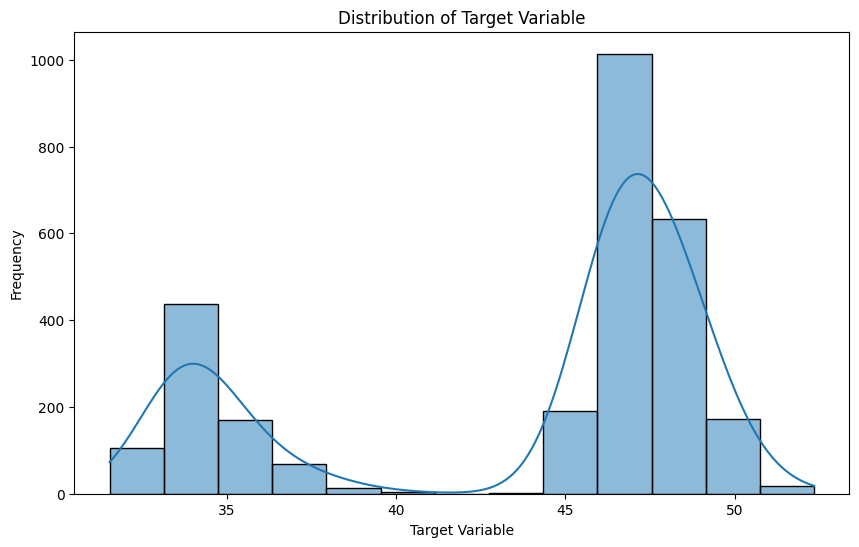

<IPython.core.display.Javascript object>

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()


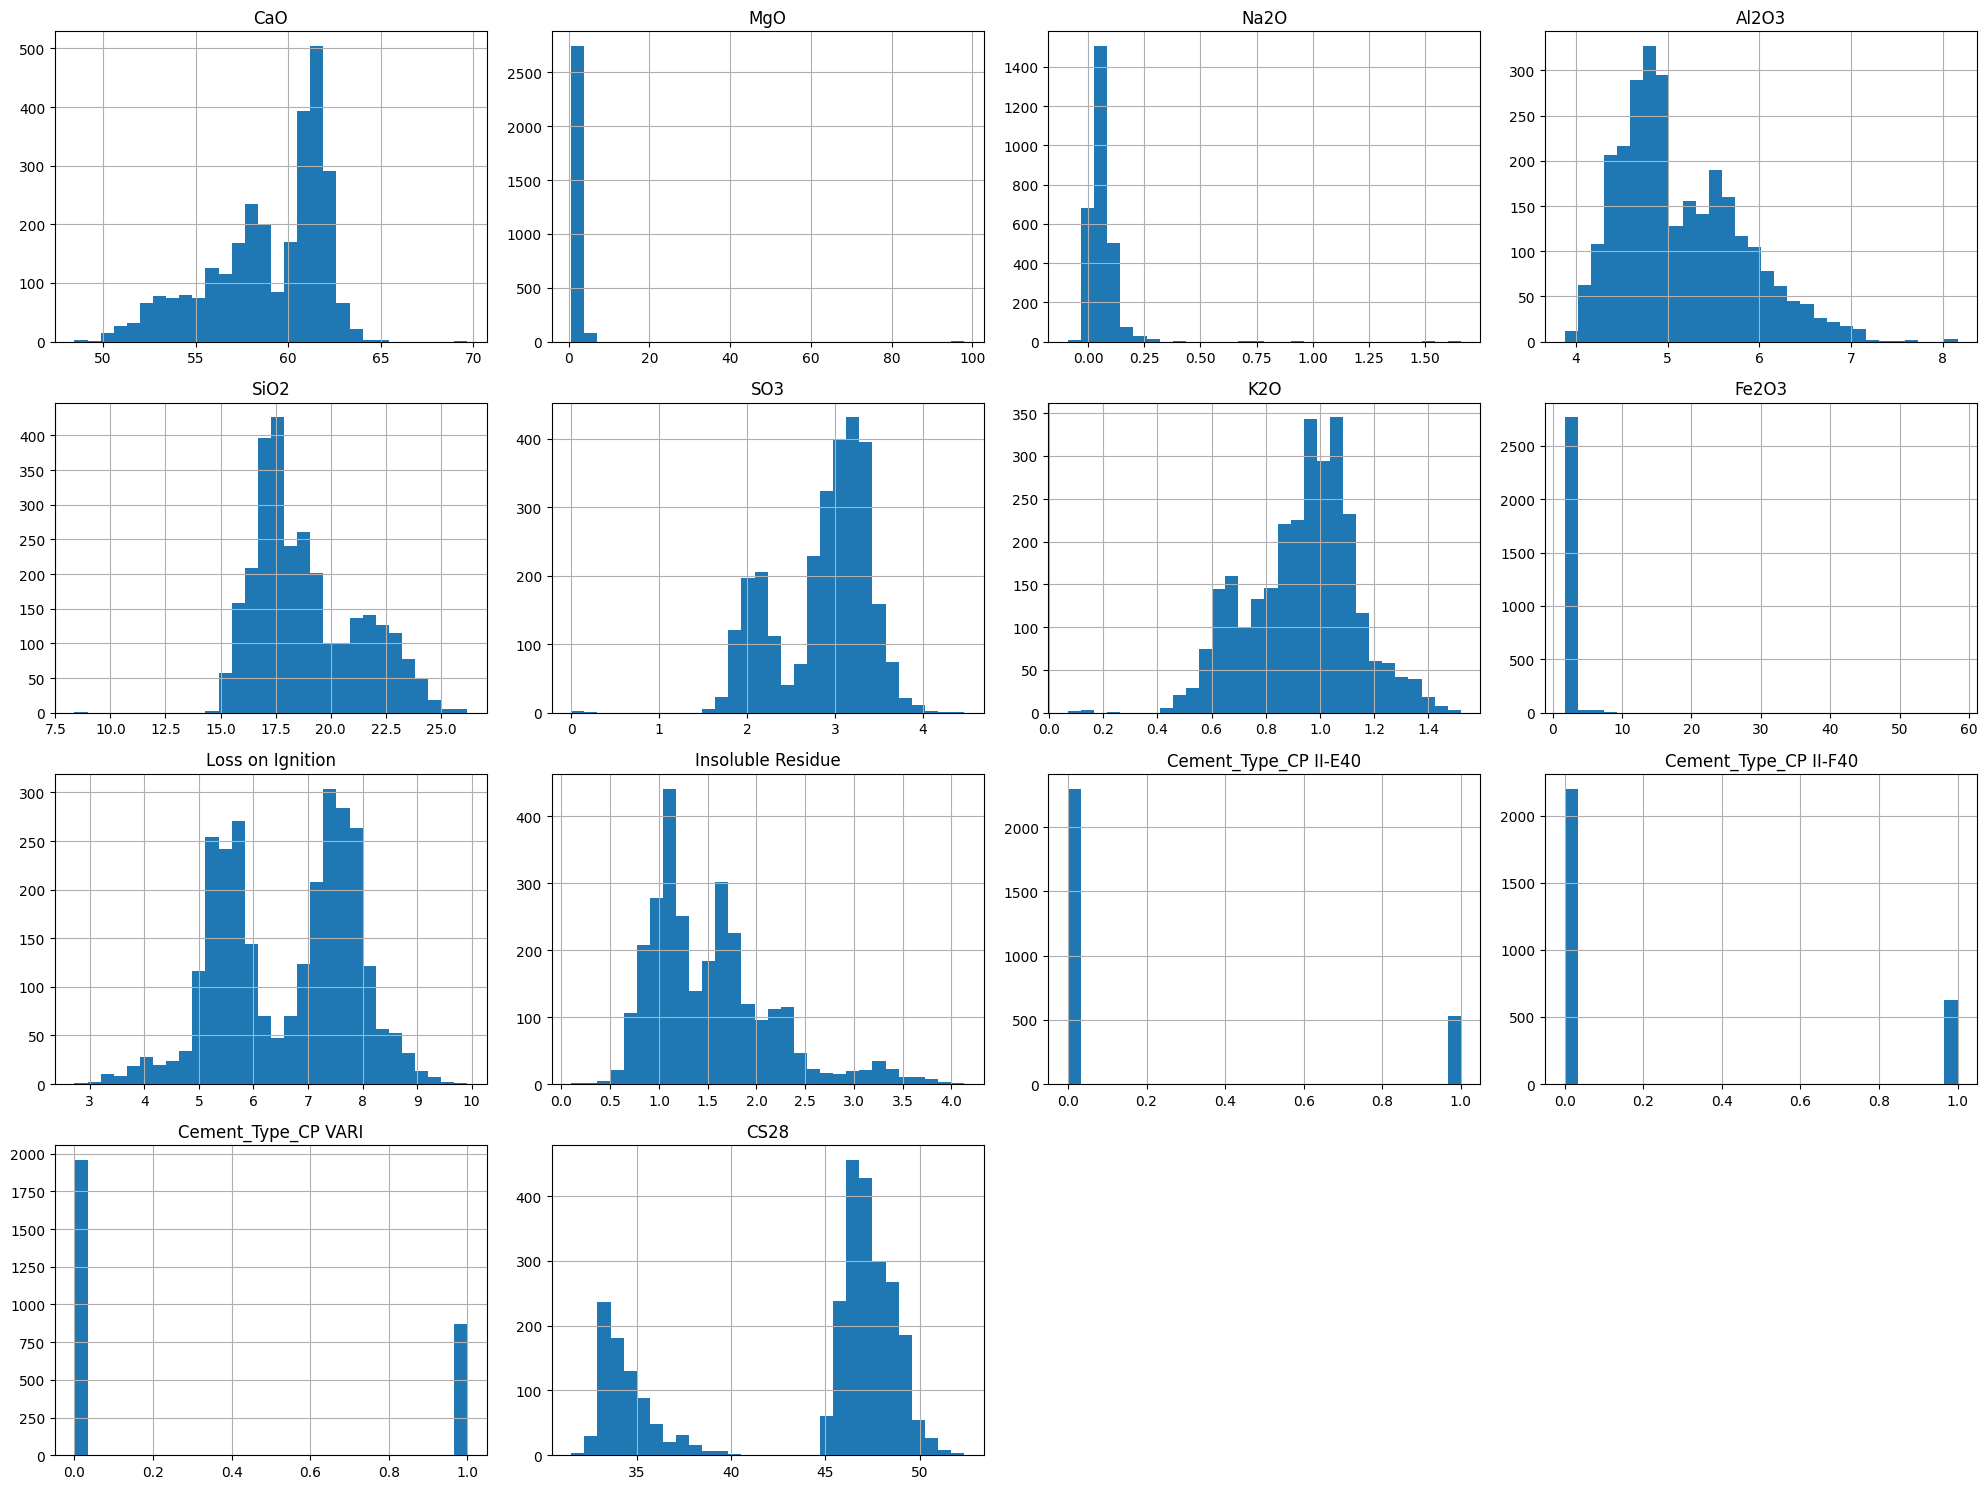

<IPython.core.display.Javascript object>

In [69]:
df_copy.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

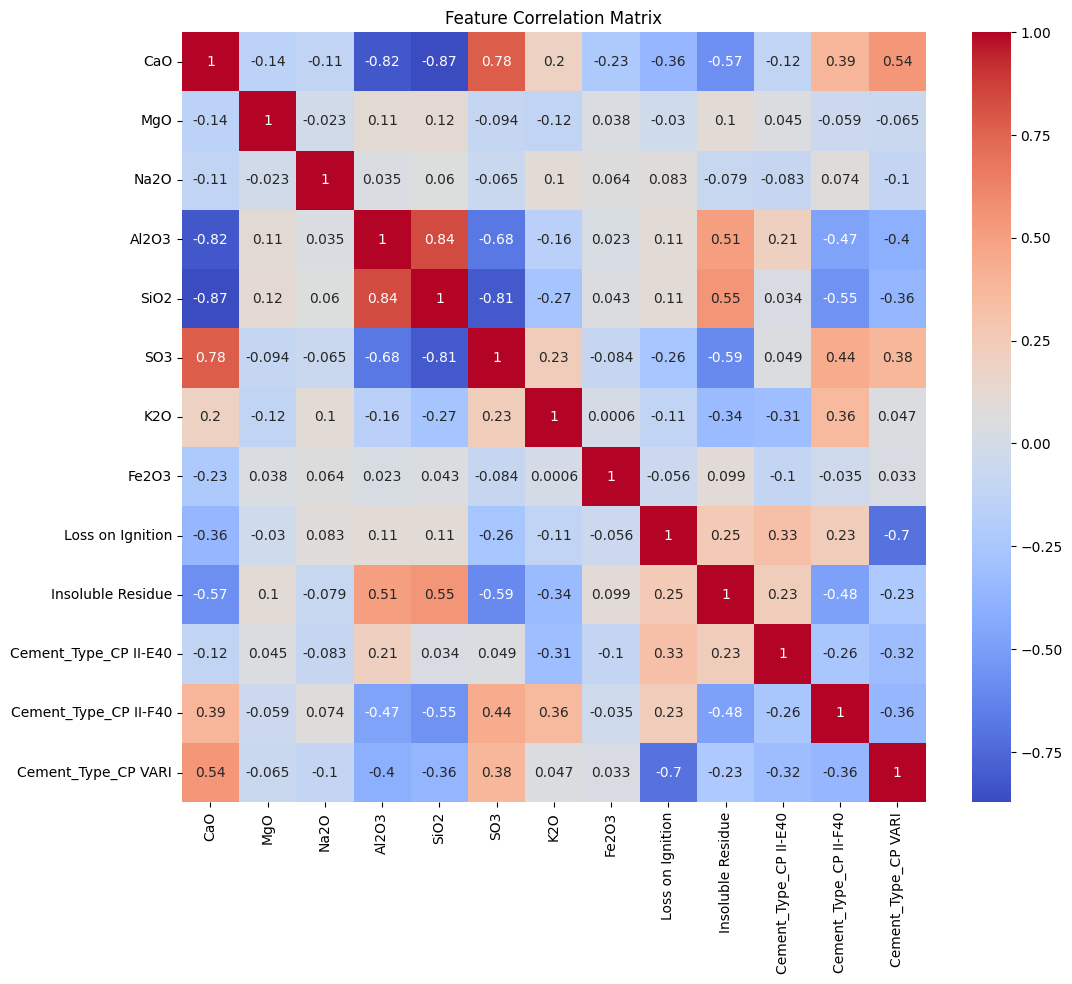

<IPython.core.display.Javascript object>

In [70]:
corr_matrix = x.drop("Date", axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


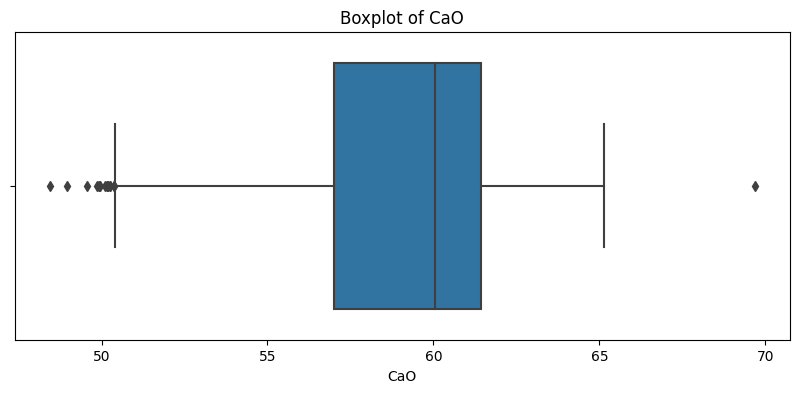

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


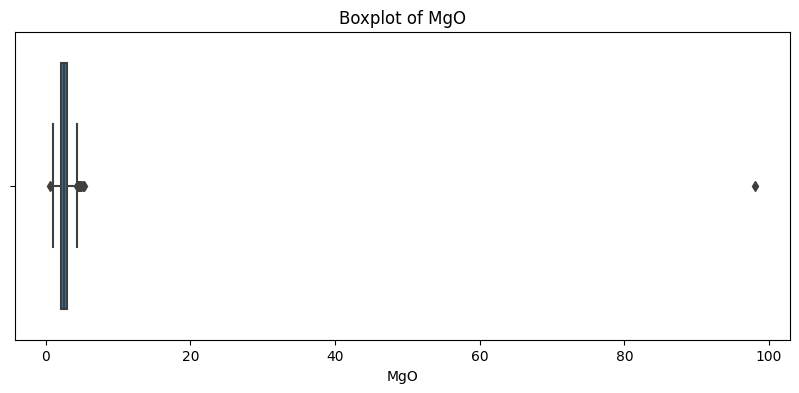

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


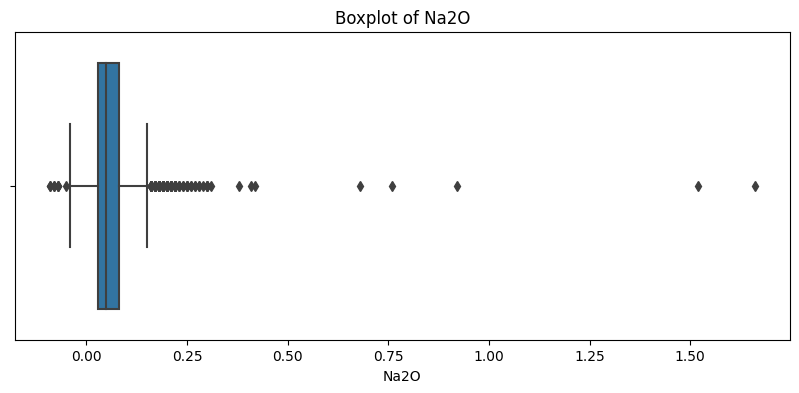

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


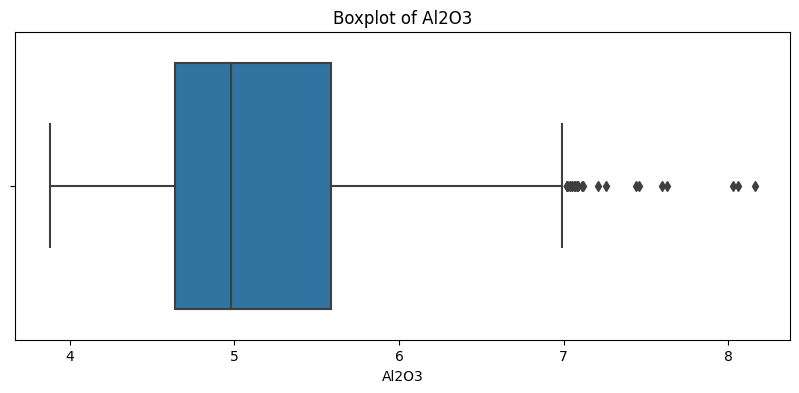

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


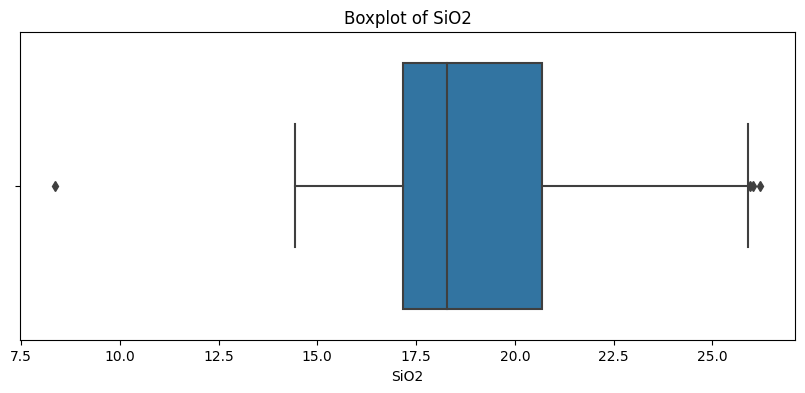

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


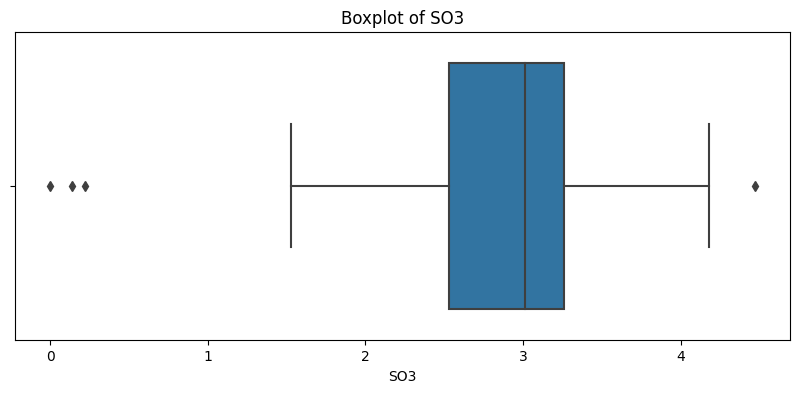

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


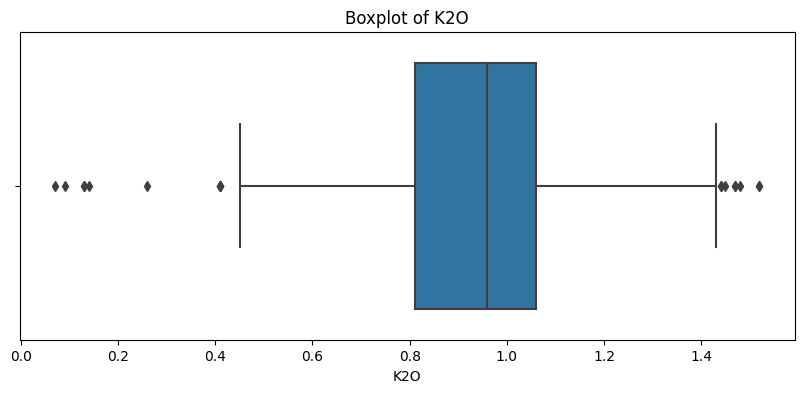

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


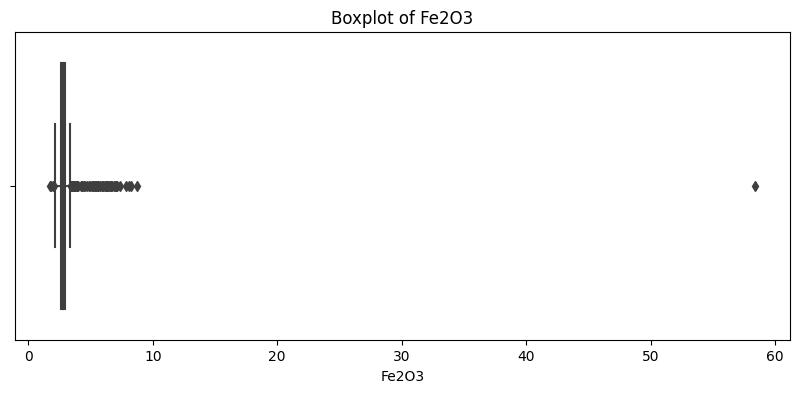

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


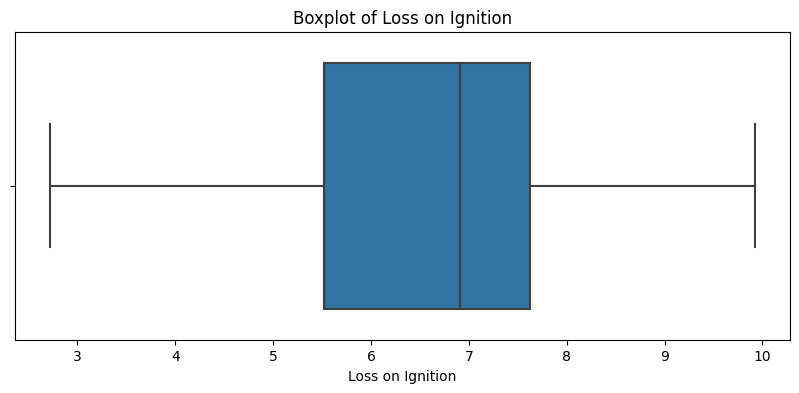

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


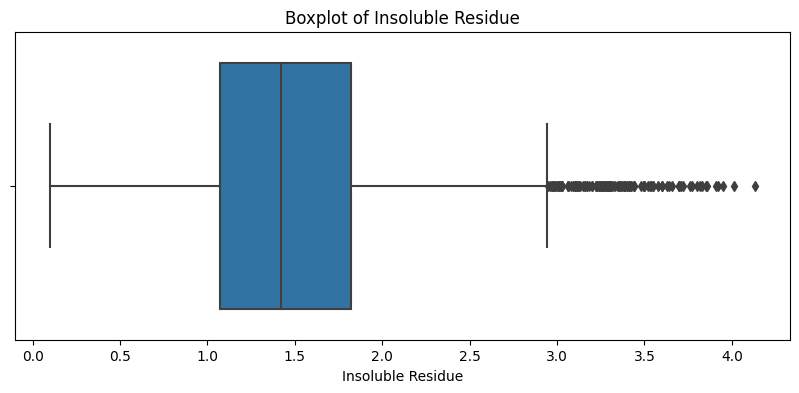

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


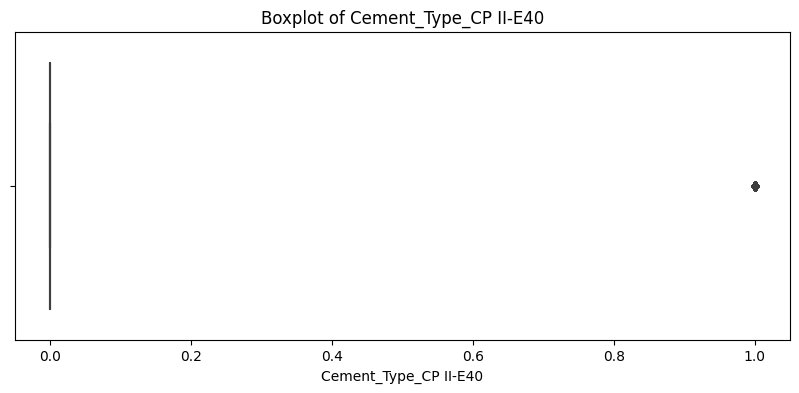

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


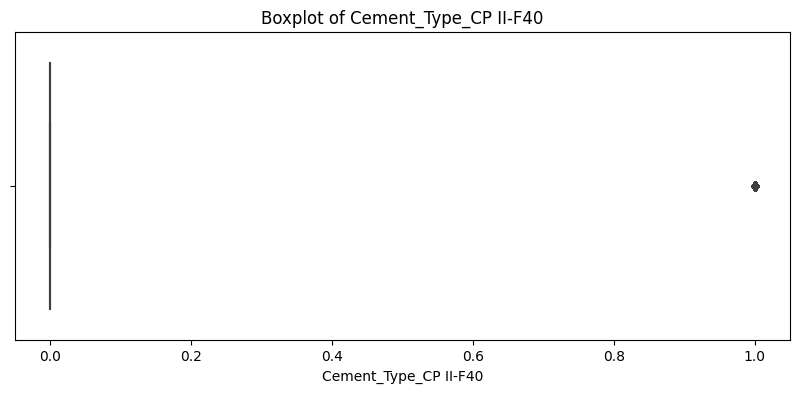

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


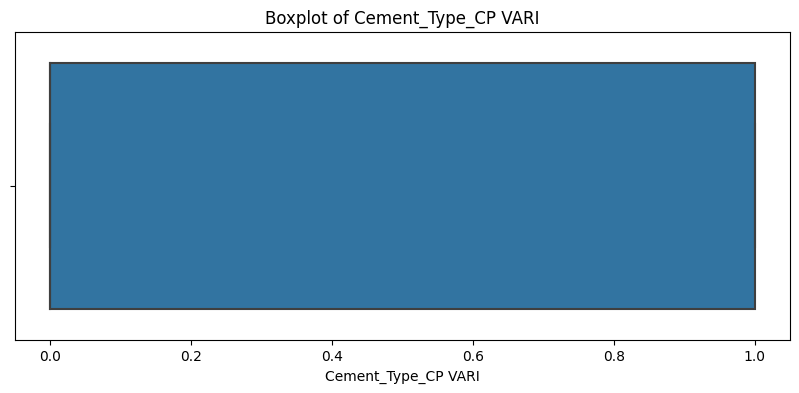

<IPython.core.display.Javascript object>

In [71]:

for column in x.drop("Date", axis=1).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=x[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


In [72]:
missing_values = df_copy.isnull().sum()
print(missing_values[missing_values > 0])


CaO                   4
MgO                   2
Na2O                 13
Al2O3                 2
SiO2                  2
SO3                   2
K2O                   2
Fe2O3                 2
Loss on Ignition      2
Insoluble Residue     1
dtype: int64


<IPython.core.display.Javascript object>

In [73]:
print(df_copy.dtypes)


Date                      object
CaO                      float64
MgO                      float64
Na2O                     float64
Al2O3                    float64
SiO2                     float64
SO3                      float64
K2O                      float64
Fe2O3                    float64
Loss on Ignition         float64
Insoluble Residue        float64
Cement_Type_CP II-E40      int64
Cement_Type_CP II-F40      int64
Cement_Type_CP VARI        int64
CS28                     float64
dtype: object


<IPython.core.display.Javascript object>

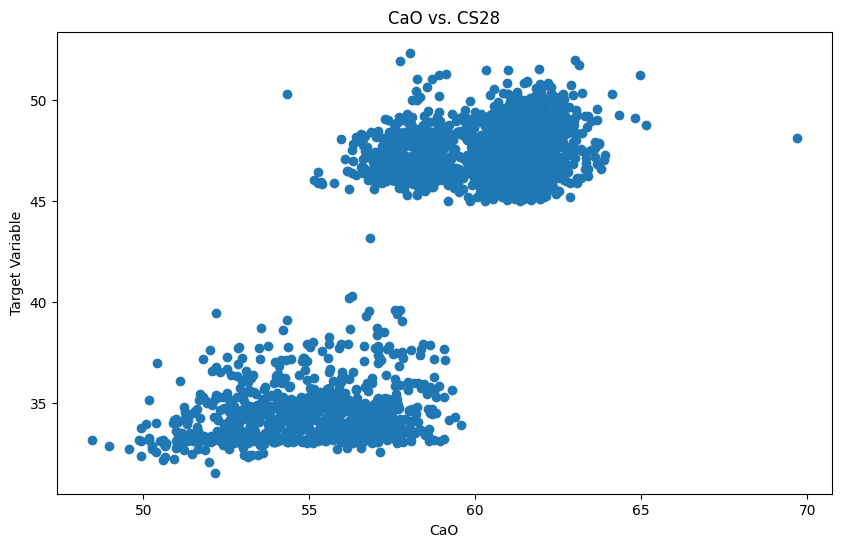

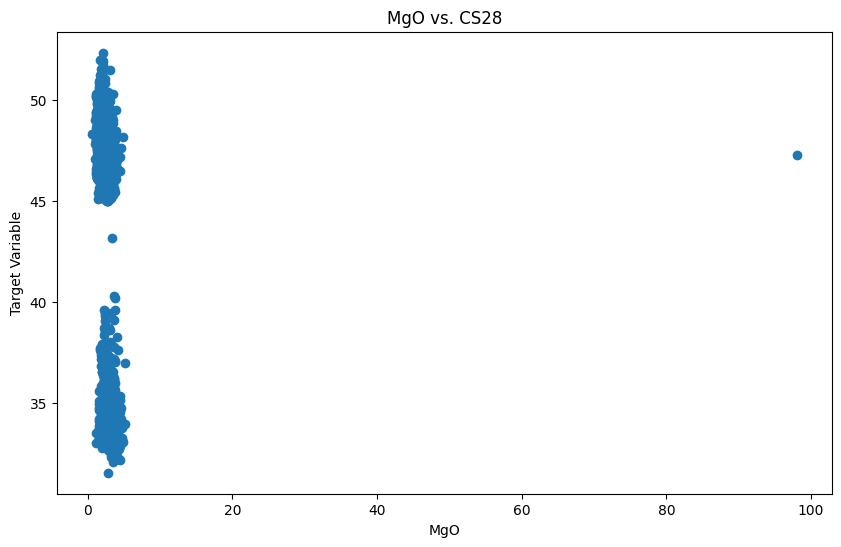

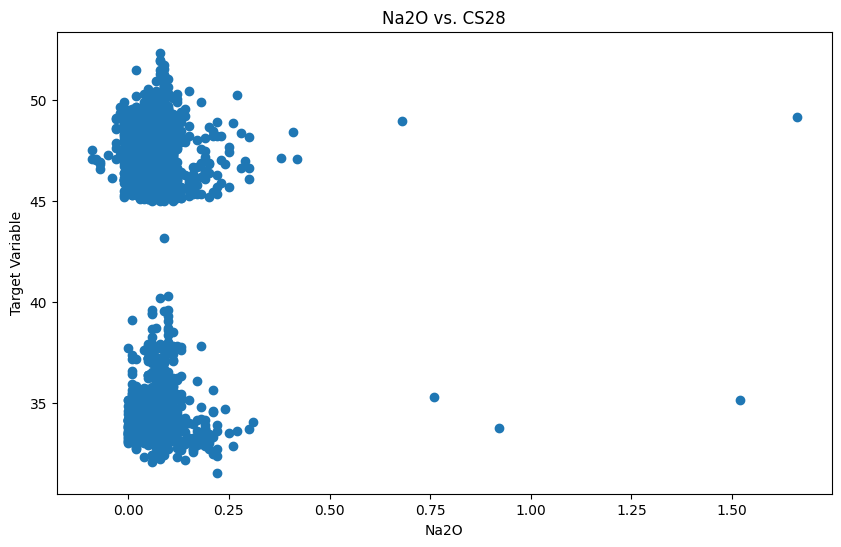

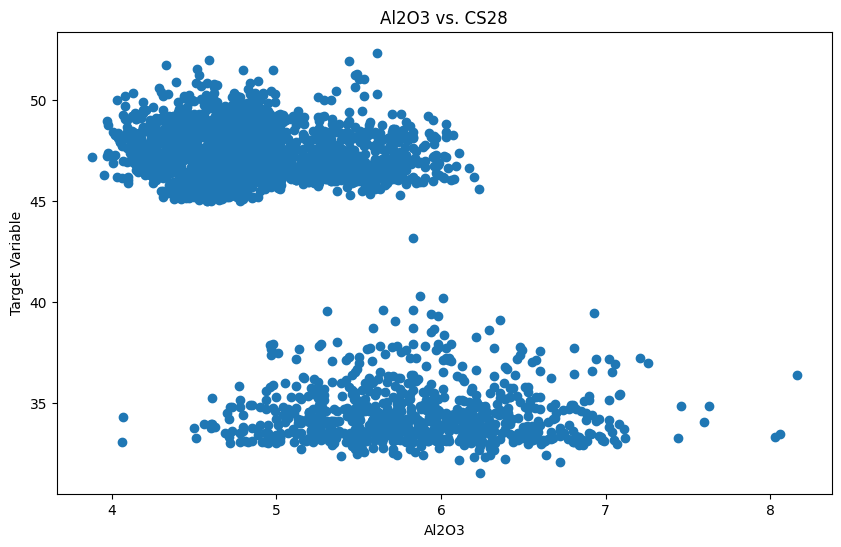

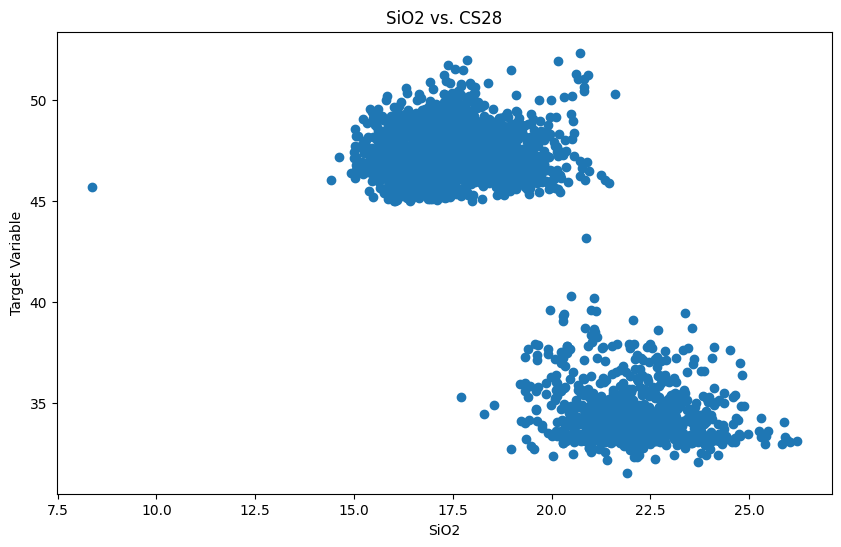

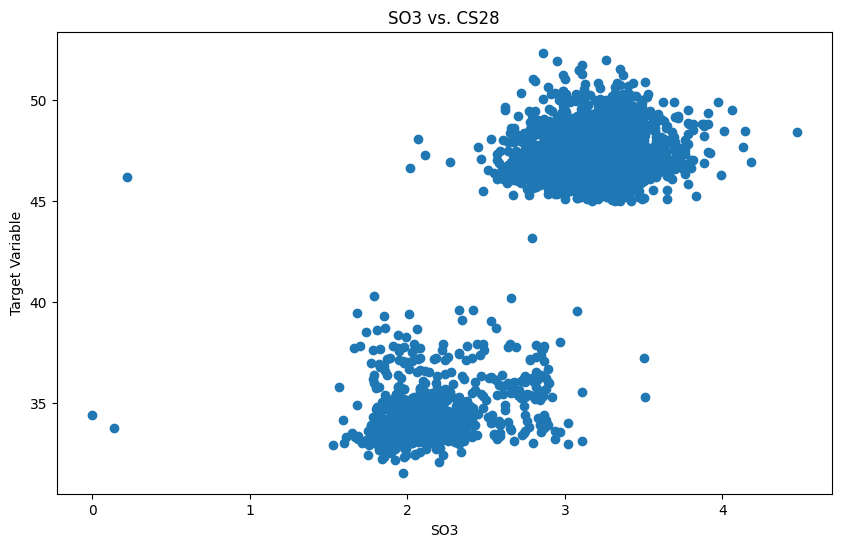

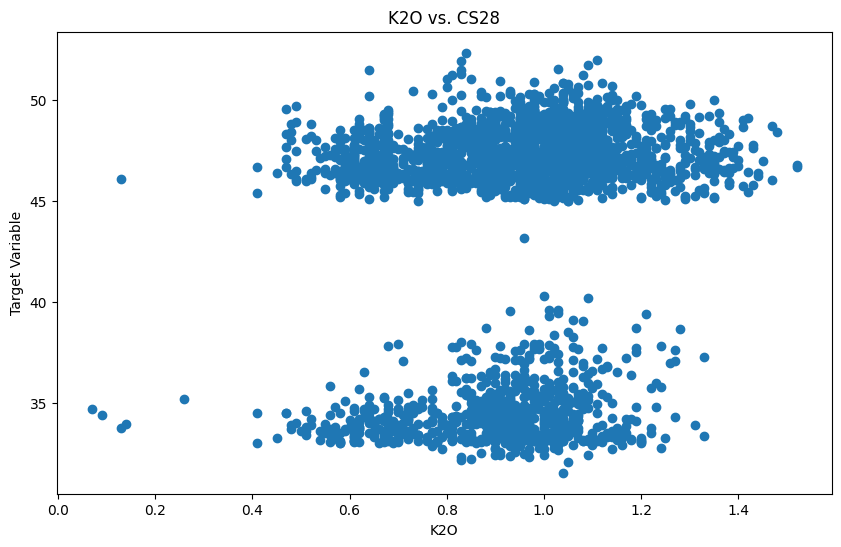

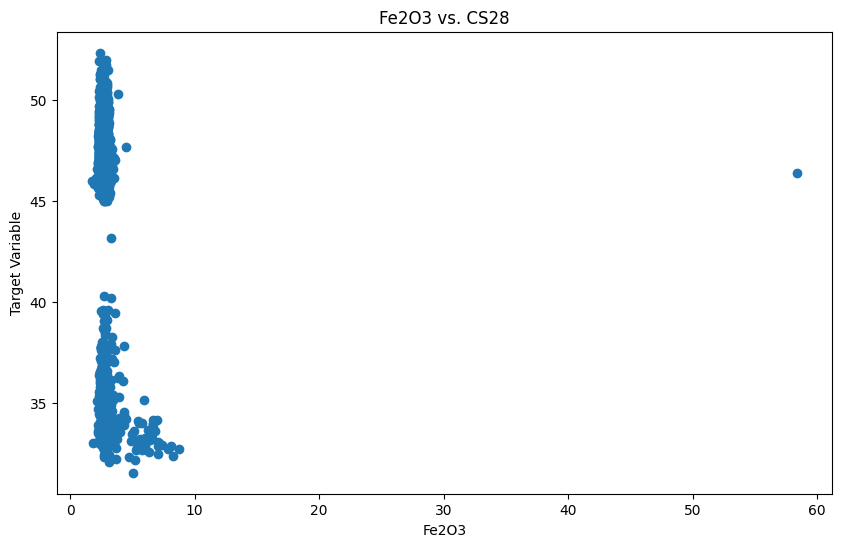

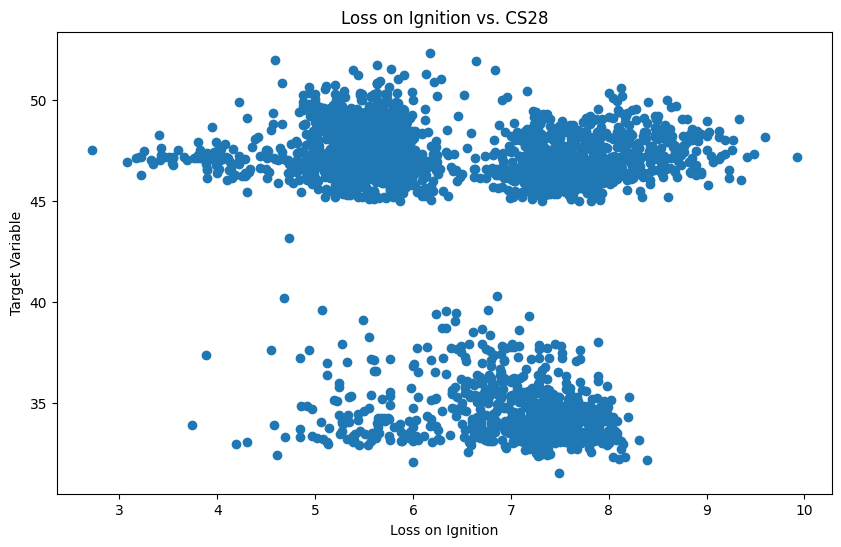

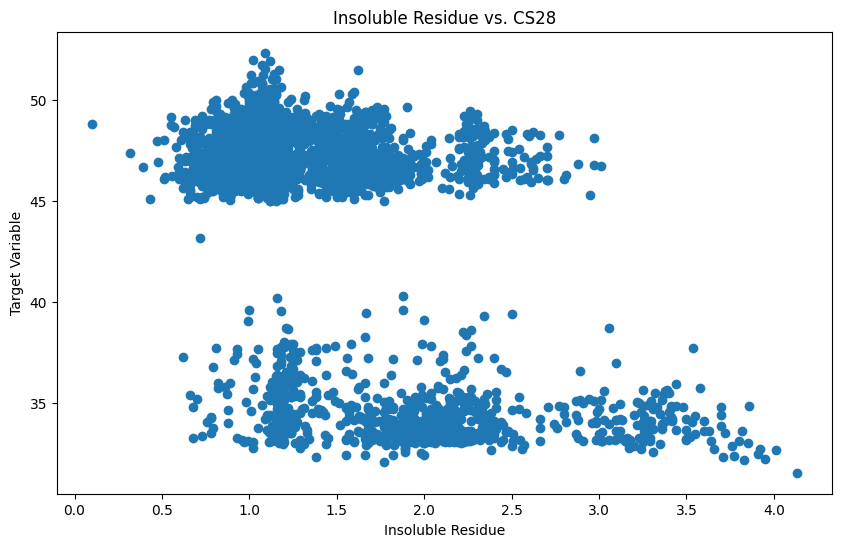

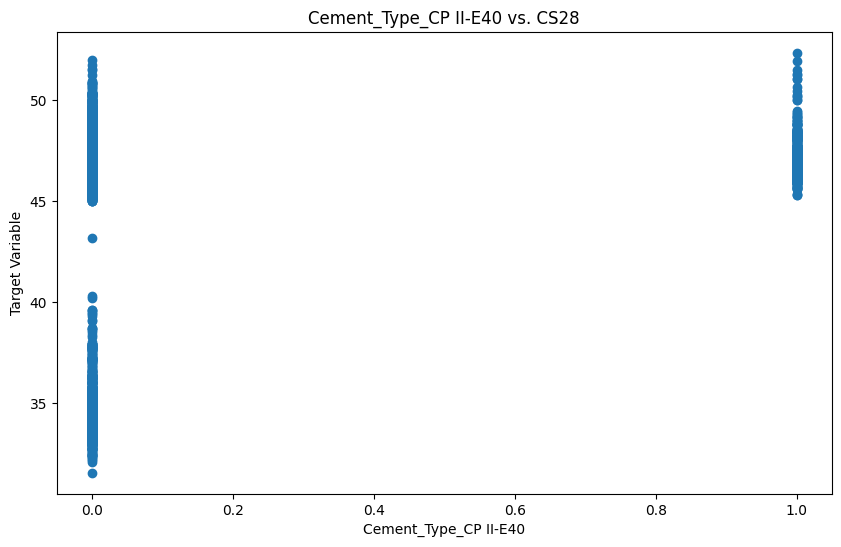

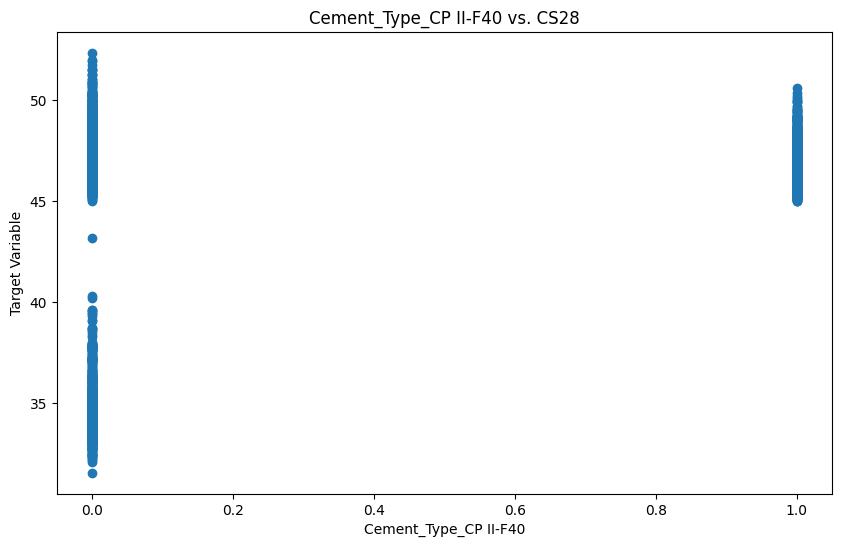

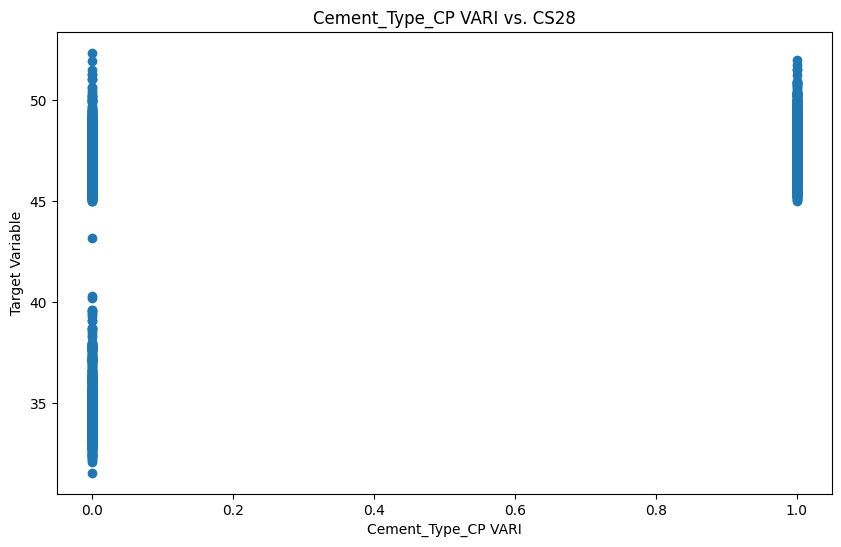

<IPython.core.display.Javascript object>

In [74]:
for column in x.drop("Date", axis=1).columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(x[column], y)
    plt.xlabel(column)
    plt.ylabel('Target Variable')
    plt.title(f'{column} vs. CS28')
    plt.show()


In [75]:
from scipy.stats import skew, kurtosis

for column in x.drop("Date", axis=1).fillna(x.drop("Date", axis=1).median()).columns:
    sk = skew(x[column].fillna(x.drop("Date", axis=1).median()))
    kt = kurtosis(x[column].fillna(x.drop("Date", axis=1).median()))
    print(f"{column}: Skewness={sk}, Kurtosis={kt}")

CaO: Skewness=nan, Kurtosis=nan
MgO: Skewness=nan, Kurtosis=nan
Na2O: Skewness=nan, Kurtosis=nan
Al2O3: Skewness=nan, Kurtosis=nan
SiO2: Skewness=nan, Kurtosis=nan
SO3: Skewness=nan, Kurtosis=nan
K2O: Skewness=nan, Kurtosis=nan
Fe2O3: Skewness=nan, Kurtosis=nan
Loss on Ignition: Skewness=nan, Kurtosis=nan
Insoluble Residue: Skewness=nan, Kurtosis=nan
Cement_Type_CP II-E40: Skewness=1.6025825608313022, Kurtosis=0.5682708642806151
Cement_Type_CP II-F40: Skewness=1.3379469056743403, Kurtosis=-0.2098980775964603
Cement_Type_CP VARI: Skewness=0.8341632170586689, Kurtosis=-1.3041717273063322


<IPython.core.display.Javascript object>

In [76]:
skew(x["CaO"].fillna(x.drop("Date", axis=1).median()))


nan

<IPython.core.display.Javascript object>

In [77]:
x.drop("Date", axis=1).fillna(x.drop("Date", axis=1).median()).isna().sum()

CaO                      0
MgO                      0
Na2O                     0
Al2O3                    0
SiO2                     0
SO3                      0
K2O                      0
Fe2O3                    0
Loss on Ignition         0
Insoluble Residue        0
Cement_Type_CP II-E40    0
Cement_Type_CP II-F40    0
Cement_Type_CP VARI      0
dtype: int64

<IPython.core.display.Javascript object>

# Transformer Encoder

In [78]:
params = get_transformer_params(
    timesteps=7,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=16,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
)

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [79]:
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
TIMESTEPS_LIST = [7]
REPEAT = 0
filenames_lists = {}
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()

for timesteps in TIMESTEPS_LIST:
    set_seeds()
    scores_final = None

    params["timesteps"] = timesteps

    for repeat in range(repeats):
        REPEAT = repeat
        x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
        y = df_copy["CS28"]
        params["num_features"] = x.shape[-1]

        cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)

        filenames_list, scores = custom_cross_validate_parallelized(
            TransformerWrapper,
            SimpleImputer,
            StandardScaler,
            x,
            y,
            cv,
            timesteps,
            dates=dates,
            cement_types=df_copy[CEMENT_TYPES],
            estimator_params={"params": params},
            imputer_params={"strategy": "median"},
            split_by_cement_type=True,
            REPEAT=REPEAT,
        )
        filenames_lists[repeat] = filenames_list
        scores = scores[0]
        if scores_final is None:
            scores_final = {key: [] for key, _ in scores.items()}

        for key, value in scores.items():
            scores_final[key] += [value]

    print("TIMESTEPS: %d " % timesteps)
    print_scores(scores_final, METRICS, METRICS_DICT)

    # Saving the results
    scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
    results_dict_copy = results_dict.copy()
    results_dict_copy["Timesteps"] = timesteps
    results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
    results_dict_copy[
        "Cross Validation Params"
    ] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
    results_dict_copy["Data Shape"] = x.shape
    df_results = fill_results_dict(results_dict_copy, scores)
    results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5



2024-11-02 00:16:35.469552: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:16:35.471635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 00:16:35.475847: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:16:35.477973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 00:16:35.502897: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical re

2024-11-02 00:19:24.138904: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:19:24.141311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 00:19:24.157474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:19:24.159538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 00:19:24.187088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024

TIMESTEPS: 7 
******
[TRAIN]
******
RMSE: 0.733 (0.101)
MAE: 0.562 (0.083)
MAPE: 0.013 (0.002)
R2: 0.984 (0.005)


******
[TEST]
******
RMSE: 2.071 (1.702)
MAE: 1.283 (0.849)
MAPE: 0.033 (0.026)
R2: 0.801 (0.341)


Minutes Elapsed:  8.474770013491312


<IPython.core.display.Javascript object>

## Plotting the Predictions

In [80]:
from tensorflow.keras.models import load_model

pipelines_final = []

for repeat in range(repeats):
    for fold in range(n_splits):
        imputer_filename = filenames_lists[repeat][fold]["imputer"]
        scaler_filename = filenames_lists[repeat][fold]["scaler"]
        model_filename = filenames_lists[repeat][fold]["model"]

        # Load the imputer
        imputer = joblib.load(imputer_filename)
        # Load the scaler
        scaler = joblib.load(scaler_filename)
        # Load the Keras model
        estimator = load_model(model_filename)

        pipelines_final.append((imputer, scaler, estimator))

<IPython.core.display.Javascript object>

In [81]:
indices_final = {"train": [], "test": []}

for repeat in range(repeats):
    for train, test in cv.split(x):
        indices_final["train"].extend([train])
        indices_final["test"].extend([test])

<IPython.core.display.Javascript object>

In [82]:
len(indices_final["train"])

15

<IPython.core.display.Javascript object>

In [83]:
def split_sequences_per_cement_type_helper(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        x, y = split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )
        return x, y, dataframe[DATE]

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())
    dates = data[DATE]

    return x, y, dates

<IPython.core.display.Javascript object>

In [84]:
def generate_sequences_helper(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        (
            dataset["x_train"],
            dataset["y_train"],
            dates_train,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        (
            dataset["x_test"],
            dataset["y_test"],
            dates_test,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
        dataset["dates_train_seq"] = dates_train
        dataset["dates_test_seq"] = dates_test
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [85]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences_helper(dataset, params["timesteps"], split_by_cement_type=True)

    if timesteps == 1:
    # Adjust dates for sequences
        dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
        dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)
    else:
        dates_train = dataset["dates_train_seq"]#.reset_index(drop=True)
        dates_test = dataset["dates_test_seq"]#.reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"], verbose=0).flatten()
    y_test_pred = estimator.predict(dataset["x_test"], verbose=0).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
        "REPEAT": [(idx)//5] * len(y_train_pred),
        #"INDEX": dates_train.index.values,
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
        "REPEAT": [(idx)//5] * len(y_test_pred),
        #"INDEX": dates_test.index.values,
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

In [86]:
# df_pred = pd.concat(all_predictions).reset_index(drop=True)
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# mean = pd.concat(
#     [
#         df_pred[df_pred["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
#         df_pred[df_pred["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
#         df_pred[df_pred["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
#     ],
#     axis=1,
# ).mean(axis=1)

# df_copy_merge = (
#     df_copy.drop(["Cement_Type_CP II-Z-32", "CS28"], axis=1)
#     .merge(df_pred, left_index=True, right_index=True, how="left")
#     .drop("REPEAT", axis=1)
# )

# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# df_copy_merge["CS28_PRED"] = mean

# df_copy_merge.to_excel("global_model_transformer_1ts_btsscv_203_c.xlsx", index=False)
# df_copy_merge.to_csv("global_model_transformer_1ts_btsscv_203_c.csv", index=False)

<IPython.core.display.Javascript object>

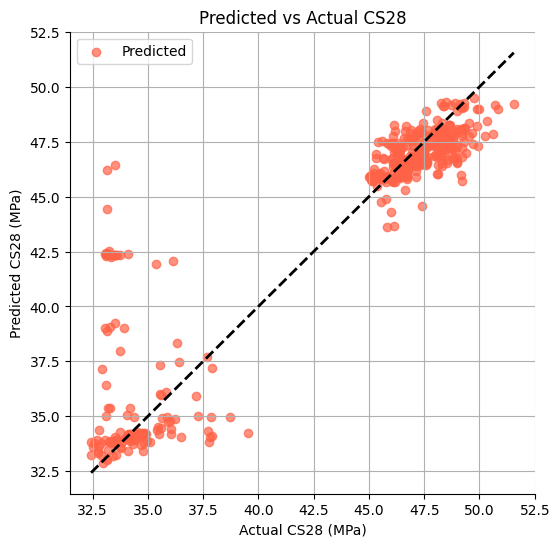

<IPython.core.display.Javascript object>

In [96]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True)],
axis=1).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_global_cm_btiss_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()


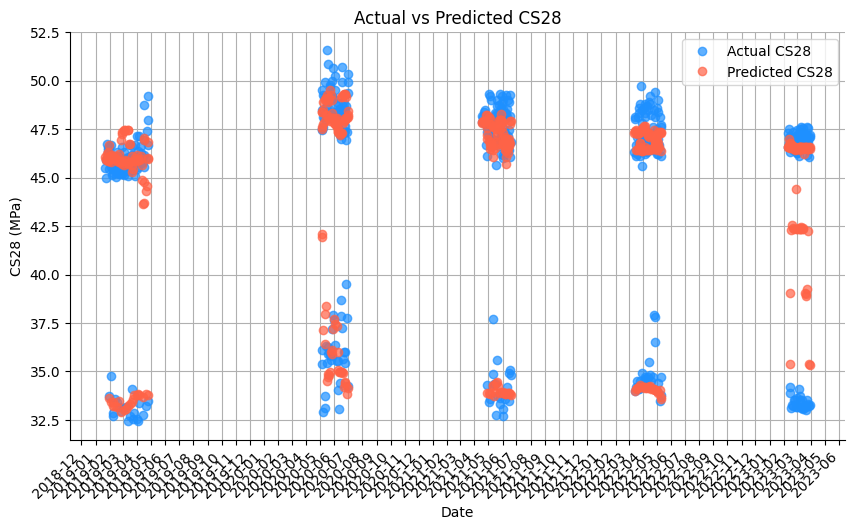

<IPython.core.display.Javascript object>

In [97]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_global_cm_btiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Feature Importance

In [98]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted, verbose=0))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [99]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for idx, (imputer, scaler, estimator) in tqdm(enumerate(pipelines_final)):
    train_index = indices_final["train"][idx]
    x_train = x.iloc[train_index].reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)

    test_index = indices_final["test"][idx]
    x_test = x.iloc[test_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

    # Preprocess x_test
    x_test_imputed = imputer.transform(x_test)
    x_test_scaled = scaler.transform(x_test_imputed)

    # Generate sequences
    dataset = {
        "x_train": x_test_scaled,
        "y_train": y_test,
        "x_test": x_test_scaled,
        "y_test": y_test,
    }
    dataset = generate_sequences(
        dataset, params["timesteps"], split_by_cement_type=False
    )
    x_test_seq = dataset["x_test"]
    y_test_seq = dataset["y_test"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

0it [00:00, ?it/s]

4/4 [==============================] - 0s 10ms/step


1it [00:11, 11.47s/it]

4/4 [==============================] - 0s 13ms/step


2it [00:22, 11.41s/it]

4/4 [==============================] - 0s 12ms/step


3it [00:34, 11.41s/it]

4/4 [==============================] - 0s 12ms/step


4it [00:45, 11.52s/it]

4/4 [==============================] - 0s 12ms/step


5it [00:57, 11.51s/it]

4/4 [==============================] - 0s 13ms/step


6it [01:09, 11.56s/it]

4/4 [==============================] - 0s 12ms/step


7it [01:20, 11.62s/it]

4/4 [==============================] - 0s 12ms/step


8it [01:32, 11.51s/it]

4/4 [==============================] - 0s 12ms/step


9it [01:43, 11.43s/it]

4/4 [==============================] - 0s 13ms/step


10it [01:54, 11.42s/it]

4/4 [==============================] - 0s 13ms/step


11it [02:06, 11.52s/it]

4/4 [==============================] - 0s 12ms/step


12it [02:17, 11.47s/it]

4/4 [==============================] - 0s 13ms/step


13it [02:29, 11.47s/it]

4/4 [==============================] - 0s 12ms/step


14it [02:40, 11.38s/it]

4/4 [==============================] - 0s 13ms/step


15it [02:52, 11.49s/it]


<IPython.core.display.Javascript object>

In [100]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [101]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
    "TiO2": r"$\mathrm{TiO_2}$",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


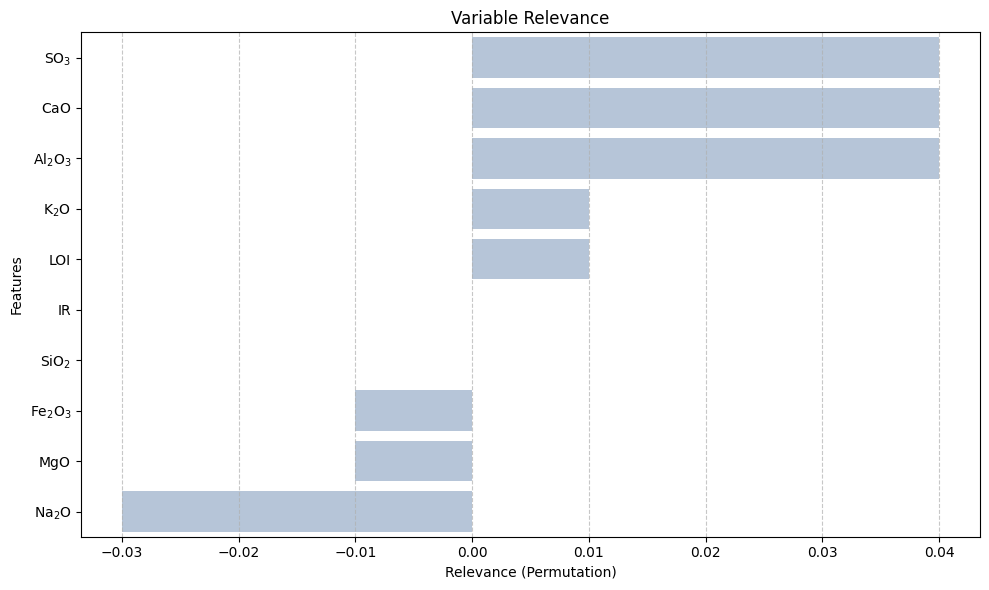

<IPython.core.display.Javascript object>

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

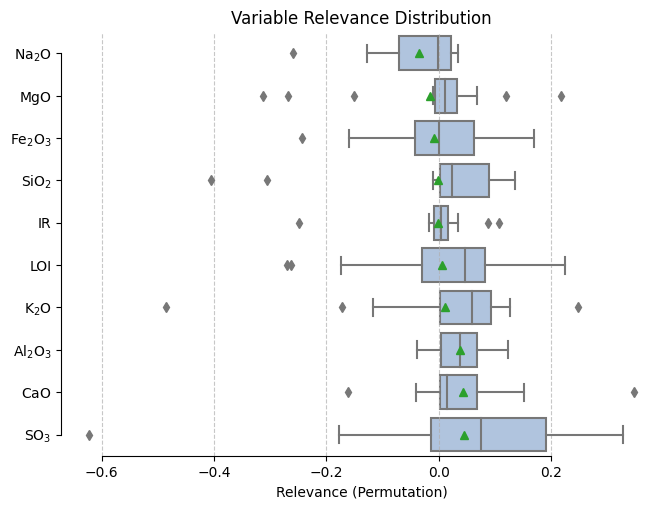

<IPython.core.display.Javascript object>

In [103]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_global_cm_btiss_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [104]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
$\mathrm{Na_2O}$,15.0,-0.034756,0.084923,-0.258990,-0.071232,-0.000796,0.021595,0.034851
$\mathrm{MgO}$,15.0,-0.014770,0.135982,-0.312497,-0.007441,0.011467,0.032397,0.217637
$\mathrm{Fe_2O_3}$,15.0,-0.007637,0.108007,-0.243917,-0.041973,0.000430,0.063553,0.169186
$\mathrm{SiO_2}$,15.0,-0.002119,0.152410,-0.405980,0.002253,0.024422,0.088558,0.136100
IR,15.0,-0.000910,0.077070,-0.247970,-0.009214,0.004651,0.016060,0.106429
LOI,15.0,0.006478,0.143279,-0.270300,-0.029975,0.046968,0.082597,0.224064
$\mathrm{K_2O}$,15.0,0.010979,0.169483,-0.485282,0.003007,0.059626,0.093138,0.247649
$\mathrm{Al_2O_3}$,15.0,0.037549,0.047466,-0.038355,0.004035,0.038534,0.067833,0.122682
$\mathrm{CaO}$,15.0,0.042822,0.109869,-0.161149,0.001749,0.014658,0.067513,0.347669
$\mathrm{SO_3}$,15.0,0.044088,0.233768,-0.623007,-0.013765,0.075378,0.191075,0.327917


<IPython.core.display.Javascript object>